### Libraries

In [2]:
#!python -m pip install spacy
#!python -m pip install spacy-language-detection
#!python -m pip install wordcloud
#!python -m pip install textblob

In [3]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
import demoji
import string
from textblob import TextBlob

import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

from collections import Counter
import string
import wordcloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import warnings
warnings.filterwarnings("ignore")
PUNCTUATION = string.punctuation

### Dataset

In [4]:
df = pd.read_csv("bot_detection_data.csv")
df = df[['Tweet','Follower Count','Verified','Bot Label']]
df.head()

,Tweet,Follower Count,Verified,Bot Label
0,Station activity person against natural majori...,2353,False,1
1,Authority research natural life material staff...,9617,True,0
2,Manage whose quickly especially foot none to g...,4363,True,0
3,Just cover eight opportunity strong policy which.,2242,True,1
4,Animal sign six data good or.,8438,False,1


In [5]:
df.shape

(50000, 4)

In [6]:
df.columns

Index(['Tweet', 'Follower Count', 'Verified', 'Bot Label'], dtype='object')

In [7]:
df.dtypes

Tweet             object
Follower Count     int64
Verified            bool
Bot Label          int64
dtype: object

### Missing Values

In [8]:
df.isnull().sum()

Tweet             0
Follower Count    0
Verified          0
Bot Label         0
dtype: int64

In [9]:
df = df.rename(columns = {"Bot Label":"account_type", 'Tweet':'tweets'})

### Feature Extraction

In [10]:
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [11]:
def getCharCount(text):
    return len(text)

def getWordsInSentence(text):
    res = sum([i.strip(string.punctuation).isalpha() for i in text.split()])
    return res

def getCaptialChar(text):
    return sum(map(str.isupper, text.split()))

def getNoSen(text):
    return len(nltk.sent_tokenize(text))

def getWordInDoubleQuote(text):
    return len(re.findall(r'["][\w\s]+["]', text))

def getNoUniqueWord(text):
    return len(set(text.split()))

def getAvgWordLenInSen(text):
    filteredSen = ''.join(filter(lambda x: x not in '".,;!-', text))
    words = [word for word in filteredSen.split() if word]
    if (len(words) != 0):
        avg = sum(map(len, words))/len(words)
        return avg
    else:
        return 0
    
def getAvgSenLen(text):
    if (getNoSen(text) != 0):
        return (getWordsInSentence(text) / getNoSen(text))
    else:
        return 0

def getNoStopWords(text):
    return len([x for x in nltk.word_tokenize(text) if x in STOPWORDS])

def getPunctuationCount(text):
    return len("".join(x for x in text if x in PUNCTUATION))

def checkUnusualExclamationInSen(text):
    res = len([i for i in text.split() if '!' in i if i.count('!') > 1])
    if (res > 0):
        return 1
    else:
        return 0
    
def getNoExclamation(text):
    return len([i for i in text.split() if '!' in i if i.count('!') > 1])

def getDoubleEqualCount(text):
    return len([i for i in text.split() if '==' in i])

def getNoPositiveWords(text):
    return len([i for i in text.split() if TextBlob(i).sentiment.polarity >= 0.5])

def getNoNegWords(text):
    return len([i for i in text.split() if TextBlob(i).sentiment.polarity <= -0.5])

In [12]:
def extractFeatures(df):
    df['charCount'] = df['tweets'].apply(lambda x: getCharCount(x))
    df['wordsInSen'] = df['tweets'].apply(lambda x: getWordsInSentence(x))
    df['capitalChar'] = df['tweets'].apply(lambda x: getCaptialChar(x))
    df['senNumber'] = df['tweets'].apply(lambda x: getNoSen(x))
    df['doubleQuoteWord'] = df['tweets'].apply(lambda x: getWordInDoubleQuote(x))
    df['uniqueWord'] = df['tweets'].apply(lambda x: getNoUniqueWord(x))
    df['avgWordLen'] = df['tweets'].apply(lambda x: getAvgWordLenInSen(x))
    df['avgSenLen'] = df['tweets'].apply(lambda x: getAvgSenLen(x))
    df['stopWordsCount'] = df['tweets'].apply(lambda x: getNoStopWords(x))
    df['punctuationCount'] = df['tweets'].apply(lambda x: getPunctuationCount(x))
    df['unusualExc'] = df['tweets'].apply(lambda x: checkUnusualExclamationInSen(x))
    df['exclamationCount'] = df['tweets'].apply(lambda x: getNoExclamation(x))
    df['doubleEqualCount'] = df['tweets'].apply(lambda x: getDoubleEqualCount(x))
    df['noPosWords'] = df['tweets'].apply(lambda x: getNoPositiveWords(x))
    df['noNegWords'] = df['tweets'].apply(lambda x: getNoNegWords(x))
    df['noNeutralWords'] = df['wordsInSen'] - (df['noPosWords'] + df['noNegWords'])
    
    return df

In [13]:
df = extractFeatures(df)

In [14]:
df.head(3)

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,avgWordLen,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords
0,Station activity person against natural majori...,2353,False,1,83,12,0,1,0,12,5.916667,12.0,2,1,0,0,0,0,0,12
1,Authority research natural life material staff...,9617,True,0,77,10,0,1,0,10,6.700000,10.0,0,1,0,0,0,0,0,10
2,Manage whose quickly especially foot none to g...,4363,True,0,61,10,0,1,0,10,5.100000,10.0,1,1,0,0,0,0,0,10


In [15]:
data = df.copy()

### Text Normalization

In [16]:
data["tweets"] = data["tweets"].str.lower()

In [17]:
data.head(2)

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,avgWordLen,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords
0,station activity person against natural majori...,2353,False,1,83,12,0,1,0,12,5.916667,12.0,2,1,0,0,0,0,0,12
1,authority research natural life material staff...,9617,True,0,77,10,0,1,0,10,6.700000,10.0,0,1,0,0,0,0,0,10


#### Function for Text Cleaning

In [18]:
def simplify(q):
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    return q.strip()

In [19]:
data["tweets"] = data["tweets"].apply(lambda i: simplify(i))

In [20]:
def Text_Cleaning(a):
    #Remove URL's
    a = re.sub(r'https?://\S+', ' ', a)
    
    #Remove Tags
    a = re.sub(r'@\w*', ' ' , a)
    
    #Remove HashTags
    a = re.sub(r'#\w*', ' ' , a)
    
    #Remove Email
    a = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*',' ', a)
    
    #Remove apostrophe
    a = re.sub(r"['’](\s)*[a-z]+", ' ', a)
    
    #Remove Number
    a = re.sub(r"[\d]+" , ' ' , a)
    
    #Remove Emoji
    a = demoji.replace(a,' ')
    
    return a

In [21]:
#Cleaning of text
data["tweets"] = data["tweets"].apply(lambda i: Text_Cleaning(i))

In [22]:
#NewLine
data['tweets'] = data["tweets"].str.replace('\n' , ' ')

In [23]:
#Punctuation
data['tweets'] = data['tweets'].str.replace(r'[^\w\s]+', ' ', regex=True)

In [24]:
spacy.load('en_core_web_sm')

In [25]:
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

def Language_Detection(txt):
    doc = nlp_model(txt)
    return (doc._.language['language'])

In [26]:
data['lan'] = data['tweets'].apply(lambda x: Language_Detection(x))

In [27]:
data[data['lan']!='en']

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan
4,animal sign six data good or,8438,False,1,29,6,0,1,0,6,...,6.0,1,1,0,0,0,1,0,5,so
13,them relate question religious require popular,6073,True,0,47,6,0,1,0,6,...,6.0,0,1,0,0,0,1,0,5,fr
18,range sell may science successful involve amou...,8305,True,1,58,8,0,1,0,8,...,8.0,0,1,0,0,0,1,0,7,it
91,most page change most none past range,987,True,1,38,7,0,1,0,7,...,7.0,1,1,0,0,0,2,0,5,fr
110,mission central idea full live reason,8534,False,0,38,6,0,1,0,6,...,6.0,0,1,0,0,0,0,0,6,it
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49924,bed building budget mind worker choose believe...,9927,False,1,69,11,0,1,0,11,...,11.0,2,1,0,0,0,0,0,11,nl
49926,like federal bank glass deal relate material,3881,False,0,45,7,0,1,0,7,...,7.0,0,1,0,0,0,0,0,7,no
49944,available value deal sit price statement vario...,2823,True,0,83,12,0,1,0,11,...,12.0,0,1,0,0,0,0,0,12,fr
49952,use home occur week represent hope interest like,7878,False,1,49,8,0,1,0,8,...,8.0,1,1,0,0,0,0,0,8,af


In [28]:
data['lan'].unique()

array(['en', 'so', 'fr', 'it', 'de', 'nl', 'cy', 'da', 'no', 'ro', 'ca',
       'af', 'sv', 'es', 'et', 'tl', 'pt', 'fi', 'sl', 'id', 'hr', 'pl'],
      dtype=object)

In [29]:
inx = data[data['lan']!='en'].index
data.drop(inx, inplace = True)

In [30]:
data[data['lan']!='en']

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan


In [31]:
def clean_func(a):
    #Remove single chr
    a = re.sub('\s*\\b([a-z]|[a-z]{2})\\b', '', a)
    
    #Remove Special Chr
    a = re.sub("[^a-zA-Z0-9\s]", ' ', a)
    
    #Remove Space
    a = re.sub(' +', " " , a.strip())
    
    return a

In [32]:
data['tweets']=data['tweets'].apply(lambda z: clean_func(z))

In [33]:
data['tweets']

0        station activity person against natural majori...
1        authority research natural life material staff...
2        manage whose quickly especially foot none goal...
3         just cover eight opportunity strong policy which
5        see wonder travel this suffer less yard office...
                               ...                        
49995    want but put card direction know miss former half
49996    provide whole maybe agree church respond most ...
49997    bring different everyone international capital...
49998    than about single generation itself seek sell ...
49999    here morning class various room human true bec...
Name: tweets, Length: 48206, dtype: object

In [34]:
data.head(2)

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan
0,station activity person against natural majori...,2353,False,1,83,12,0,1,0,12,...,12.0,2,1,0,0,0,0,0,12,en
1,authority research natural life material staff...,9617,True,0,77,10,0,1,0,10,...,10.0,0,1,0,0,0,0,0,10,en


### Remove stop words 

In [35]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])


data["tweets"] = data['tweets'].apply(lambda x: remove_stopwords(x))

In [36]:
data[data['tweets']=='']

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan


In [37]:
iname = data[data['tweets']==''].index
data.drop(iname, inplace = True)

In [38]:
data.reset_index(inplace = True)  

In [39]:
data

,index,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan
0,0,station activity person natural majority none ...,2353,False,1,83,12,0,1,0,...,12.0,2,1,0,0,0,0,0,12,en
1,1,authority research natural life material staff...,9617,True,0,77,10,0,1,0,...,10.0,0,1,0,0,0,0,0,10,en
2,2,manage whose quickly especially foot none goal...,4363,True,0,61,10,0,1,0,...,10.0,1,1,0,0,0,0,0,10,en
3,3,cover eight opportunity strong policy,2242,True,1,49,7,0,1,0,...,7.0,1,1,0,0,0,0,0,7,en
4,5,see wonder travel suffer less yard office man ...,3792,True,1,61,10,0,1,0,...,10.0,1,1,0,0,0,0,0,10,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48201,49995,want put card direction know miss former half,9911,True,1,50,9,0,1,0,...,9.0,1,1,0,0,0,0,0,9,en
48202,49996,provide whole maybe agree church respond base ...,9900,False,1,86,13,0,1,0,...,13.0,2,1,0,0,0,2,1,10,en
48203,49997,bring different everyone international capital...,6313,True,1,63,7,0,1,0,...,7.0,0,1,0,0,0,0,0,7,en
48204,49998,single generation seek sell still hour,6343,False,0,61,10,0,1,0,...,10.0,3,1,0,0,0,0,0,10,en


### Wordcloud 'Bot'

(-0.5, 999.5, 799.5, -0.5)

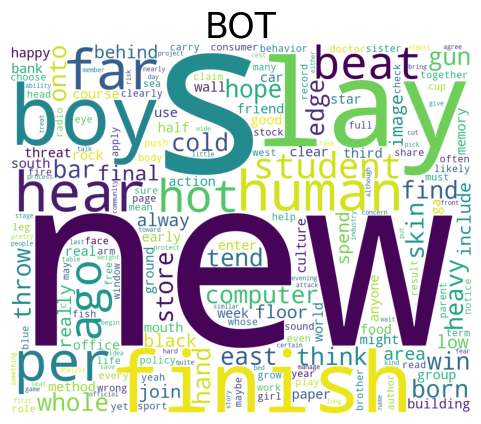

In [40]:
df_bot = data[data['account_type']==1]
bot = df_bot['tweets'].to_string(index=False)
plt.title('BOT', fontsize=25)
bot_wordcloud=WordCloud(width=1000, height=800, background_color='white').generate(bot)
plt.imshow(bot_wordcloud)
plt.axis('off')

### Wordcloud 'Human'

(-0.5, 999.5, 799.5, -0.5)

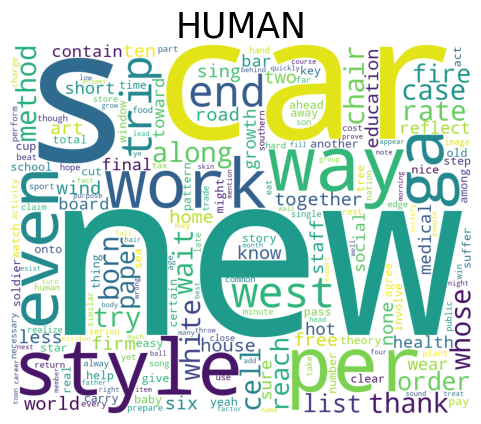

In [41]:
df_human = data[data['account_type']==0]
human = df_human['tweets'].to_string(index=False)

plt.title('HUMAN', fontsize=25)
human_wordcloud=WordCloud(width=1000, height=800, background_color='white').generate(human)
plt.imshow(human_wordcloud)
plt.axis('off')

### Stemming 

In [42]:
# Define a function to stem a sentence
def stem_sentence(sentence):

        # Initialize PorterStemmer
    stemmer = SnowballStemmer(language='english')

        # Tokenize the sentence into words
    words = word_tokenize(sentence)

        # Stem each word and return the stemmed sentence
    return ' '.join([stemmer.stem(word) for word in words])
    
dfx = data.copy()
dfx['tweets'] = dfx['tweets'].apply(stem_sentence)
print("Stemming Completed!")

Stemming Completed!


In [43]:
n_sample = 3
samples = np.random.randint(0,len(dfx['tweets'])-1,n_sample)
for i in range(len(samples)):
    print(f"Sample# {i+1}")
    print()
    print("ORIGINAL")
    print(data['tweets'][samples[i]])
    print("."*125)
    print('STEMMED')
    print(dfx['tweets'][samples[i]])
    print("_"*125)

Sample# 1

ORIGINAL
seat seek seven include line sell month
.............................................................................................................................
STEMMED
seat seek seven includ line sell month
_____________________________________________________________________________________________________________________________
Sample# 2

ORIGINAL
game pick almost reach thing car
.............................................................................................................................
STEMMED
game pick almost reach thing car
_____________________________________________________________________________________________________________________________
Sample# 3

ORIGINAL
little read outside mean subject peace daughter
.............................................................................................................................
STEMMED
littl read outsid mean subject peac daughter
________________________________________________

### Lemmatization

In [44]:
nlp1 = spacy.load('en_core_web_sm')
def newlemma(sentence):
    doc = nlp1(sentence)
    
    return ' '.join([token.lemma_ for token in doc])
dflm = data.copy()
dflm['tweets'] = data['tweets'].apply(newlemma)
print("Lemmatization Completed!")

Lemmatization Completed!


In [45]:
data[data['lan'] != 'en'] 

,index,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan


In [46]:
n_sample = 3
samples = np.random.randint(0,len(data['tweets'])-1,n_sample)
for i in range(len(samples)):
    print(f"Sample# {i+1}")
    print()
    print("ORIGINAL")
    print(data['tweets'][samples[i]])
    print("."*125)
    print('Lammetized')
    print(dflm['tweets'][samples[i]])
    print("_"*125)

Sample# 1

ORIGINAL
analysis purpose set night find
.............................................................................................................................
Lammetized
analysis purpose set night find
_____________________________________________________________________________________________________________________________
Sample# 2

ORIGINAL
prepare particular show even learn place group listen official attack
.............................................................................................................................
Lammetized
prepare particular show even learn place group listen official attack
_____________________________________________________________________________________________________________________________
Sample# 3

ORIGINAL
cause benefit become ball interest official approach performance deep view
.............................................................................................................................
Lammetize

### Data Visualization

<Axes: xlabel='account_type', ylabel='count'>

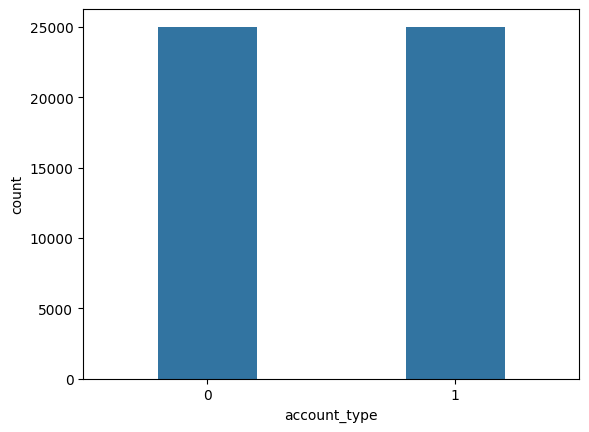

In [47]:
sns.countplot(data=df , x = 'account_type' , width = 0.4)

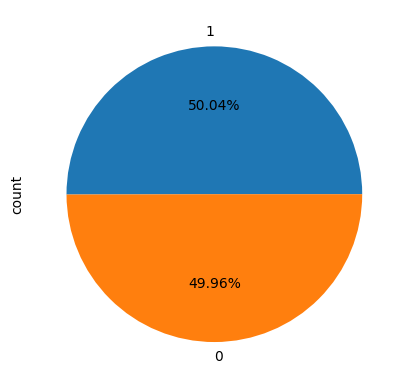

In [48]:
_ = df['account_type'].value_counts().plot.pie(autopct='%1.2f%%')

- Above plot depicts that human and bot has equal no. of tweets in data

In [49]:
dfnew = df.copy()

In [50]:
# count number of characters in each tweet
dfnew['char_len'] = dfnew.tweets.str.len()

# count number of words in each tweet
# word_tokens = [len(word_tokenize(tweet)) for tweet in dfnew.tweets]
dfnew['word_len'] = dfnew.tweets.apply(lambda x: len(word_tokenize(x)))

# count number of sentence in each tweet
# sent_tokens = [len(sent_tokenize(tweet)) for tweet in dfnew.tweets]
dfnew['sent_len'] = dfnew.tweets.apply(lambda x: len(sent_tokenize(x)))

In [51]:
dfnew.head(2)

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,...,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,char_len,word_len,sent_len
0,Station activity person against natural majori...,2353,False,1,83,12,0,1,0,12,...,1,0,0,0,0,0,12,83,13,1
1,Authority research natural life material staff...,9617,True,0,77,10,0,1,0,10,...,1,0,0,0,0,0,10,77,11,1


#### Plot of Tweets Character Count between 'Human' and 'Bot'

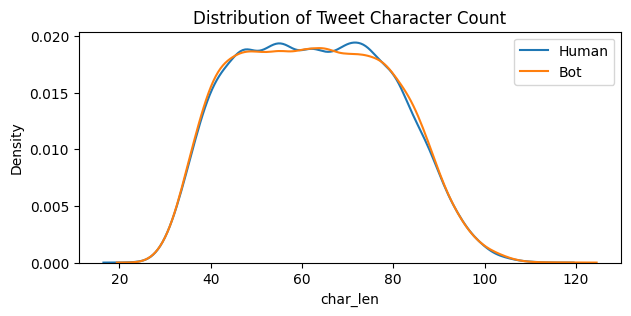

In [52]:
fig, ax = plt.subplots(figsize = (7, 3))

#create graphs
sns.kdeplot(dfnew['char_len'][dfnew['account_type'] == 0], label = 'Human')
sns.kdeplot(dfnew['char_len'][dfnew['account_type'] == 1], label = 'Bot')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.legend()
plt.show()

#### Plot of Tweets Word Count between 'Human' and 'Bot'

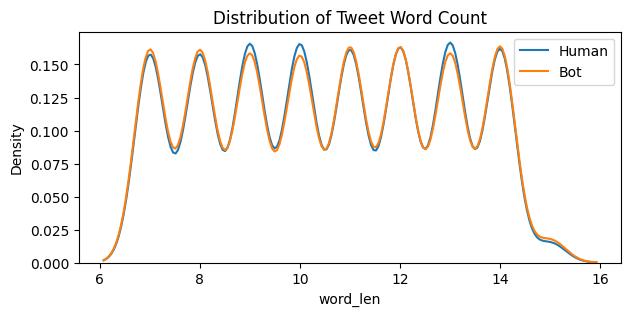

In [53]:
fig, ax = plt.subplots(figsize = (7, 3))

#create graphs
sns.kdeplot(dfnew['word_len'][dfnew['account_type'] == 0], label = 'Human')
sns.kdeplot(dfnew['word_len'][dfnew['account_type'] == 1], label = 'Bot')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.legend()
plt.show()

#### Plot of Tweets Sentence Count between 'Human' and 'Bot'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


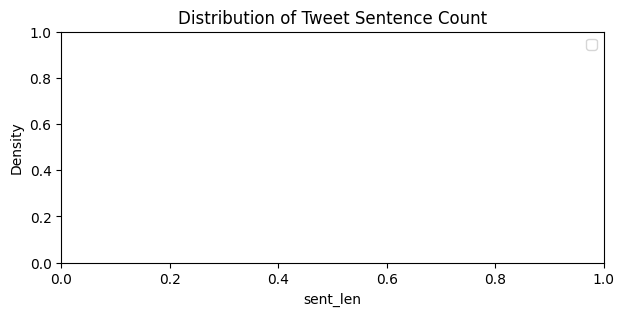

In [54]:
fig, ax = plt.subplots(figsize = (7, 3))

#create graphs
sns.kdeplot(dfnew['sent_len'][dfnew['account_type'] == 0], label = 'Human')
sns.kdeplot(dfnew['sent_len'][dfnew['account_type'] == 1], label = 'Bot')

#set title and plot
plt.title('Distribution of Tweet Sentence Count')
plt.legend()
plt.show()

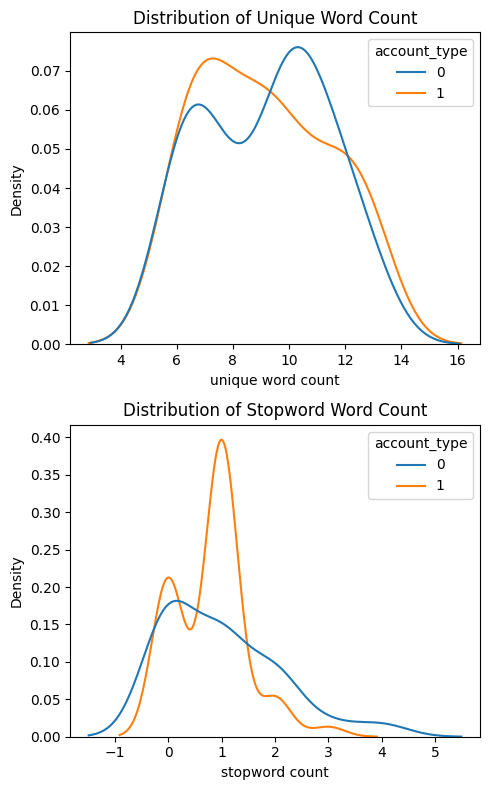

In [55]:
#add unique word count
dfnew['unique word count'] = dfnew['tweets'].apply(lambda x: len(set(x.split())))

#add stopword count
dfnew['stopword count'] = dfnew['tweets'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#split so we can use updated train set
train = dfnew[:100]

human = train['account_type'] == 0

#produce graphs to visualize newly added features
fig, axes = plt.subplots(2, figsize=(5, 8))

graph1 = sns.kdeplot(data = train , x = 'unique word count', hue='account_type' , ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(data = train , x = 'stopword count', hue='account_type' , ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

fig.tight_layout()
plt.show()

#### Top 10 most common words in 'Human' and 'Bot'

Text(0.5, 1.0, "Top 10 words and their occurences for 'Human'")

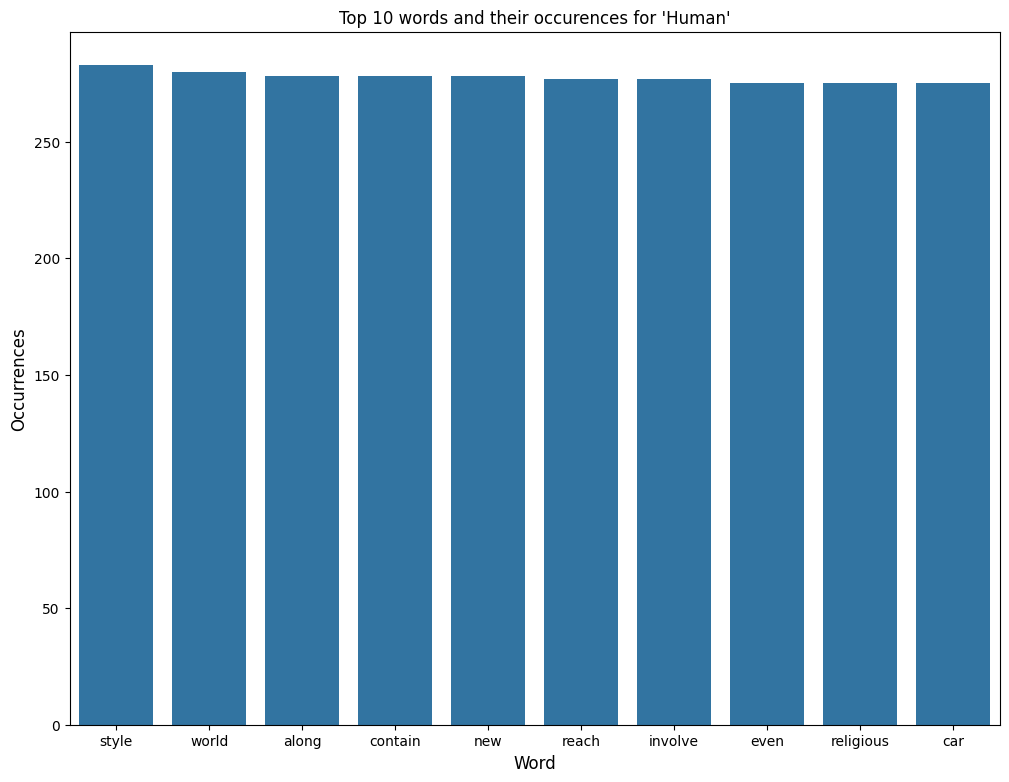

In [56]:
# Plotting word lenghts of tweets using the matplotlib
length_of_word = data[data["account_type"]==0]['tweets'].str.findall(r"(\w+)").explode().value_counts()
top_10 = length_of_word.nlargest(10)

fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x=top_10.index, y=top_10.values, ax=ax)
ax.set_ylabel('Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
plt.title("Top 10 words and their occurences for 'Human'")

Text(0.5, 1.0, "Top 10 words and their occurences for 'Bot'")

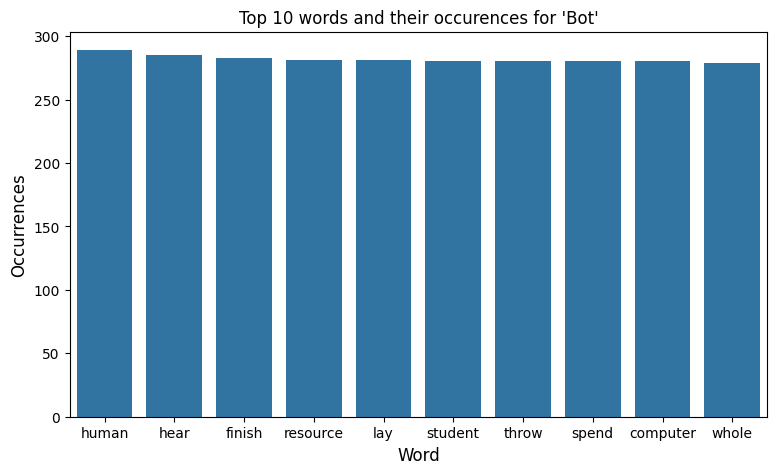

In [57]:
# Plotting word lenghts of tweets using the matplotlib
length_of_word = data[data["account_type"]==1]['tweets'].str.findall(r"(\w+)").explode().value_counts()
top_10 = length_of_word.nlargest(10)

fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x=top_10.index, y=top_10.values, ax=ax)
ax.set_ylabel('Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
plt.title("Top 10 words and their occurences for 'Bot'")

In [58]:
dflm.account_type.unique()

array([1, 0], dtype=int64)

In [59]:
# dflm.loc[dflm['account_type']==0 , 'account_type'] = 1
# dflm.loc[dflm['account_type']==1 , 'account_type'] = 0
# dflm['account_type']=dflm['account_type'].astype('int64')

In [60]:
# Remove column name 'index'
dflm.drop(['index'], axis=1 , inplace = True,errors='ignore')

In [61]:
dflm.head(2)

,tweets,Follower Count,Verified,account_type,charCount,wordsInSen,capitalChar,senNumber,doubleQuoteWord,uniqueWord,...,avgSenLen,stopWordsCount,punctuationCount,unusualExc,exclamationCount,doubleEqualCount,noPosWords,noNegWords,noNeutralWords,lan
0,station activity person natural majority none ...,2353,False,1,83,12,0,1,0,12,...,12.0,2,1,0,0,0,0,0,12,en
1,authority research natural life material staff...,9617,True,0,77,10,0,1,0,10,...,10.0,0,1,0,0,0,0,0,10,en


### Tf-IDf Vectorizer

In [62]:
"""
Tf-IDf Vectorizer
"""
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
# scaling the features columns
extracted_features = ['charCount', 'wordsInSen', 'capitalChar', 'senNumber', 'doubleQuoteWord', 'uniqueWord', 'avgWordLen', 'avgSenLen', 'stopWordsCount', 'punctuationCount', 'unusualExc', 'exclamationCount', 'doubleEqualCount', 'noPosWords', 'noNegWords', 'noNeutralWords']
scaler = MinMaxScaler()
vectorizer = TfidfVectorizer(use_idf=True, norm='l2', smooth_idf=True)
def scalingFeatures(df):
    extracted_features_data= df.loc[:, extracted_features]
    return pd.DataFrame(scaler.fit_transform(extracted_features_data))

In [64]:
# getting the merged dataframe having both extracted features and tfidf of text column
def getMergedDf(dflm, scaledDf):
    df_tf_vectorizer = vectorizer.fit(dflm['tweets'])
    df_tf_vect = df_tf_vectorizer.transform(dflm['tweets']).toarray()
    df_tf = pd.DataFrame(df_tf_vect)
#     print(df_tf)
    return pd.merge(df_tf, scaledDf, left_index=True, right_index=True)
#     return df_tf

In [65]:
# get merged dataframe 
scaledDf = scalingFeatures(dflm)
mergedDf = getMergedDf(dflm, scaledDf)
print('shape of merged df is ', mergedDf.shape)

shape of merged df is  (48206, 888)


In [66]:
scaledDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.631579,0.750,0.0,0.0,0.0,0.777778,0.500000,0.750,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.818182
1,0.568421,0.500,0.0,0.0,0.0,0.555556,0.627027,0.500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
2,0.400000,0.500,0.0,0.0,0.0,0.555556,0.367568,0.500,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
3,0.273684,0.125,0.0,0.0,0.0,0.222222,0.513514,0.125,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.363636
4,0.400000,0.500,0.0,0.0,0.0,0.555556,0.367568,0.500,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48201,0.284211,0.375,0.0,0.0,0.0,0.444444,0.279279,0.375,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.545455
48202,0.663158,0.875,0.0,0.0,0.0,0.888889,0.451143,0.875,0.285714,0.0,0.0,0.0,0.0,0.5,0.5,0.636364
48203,0.421053,0.125,0.0,0.0,0.0,0.222222,0.837838,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.363636
48204,0.400000,0.500,0.0,0.0,0.0,0.555556,0.367568,0.500,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.636364


In [67]:
(mergedDf.columns == 'Follower Count').any()

False

In [68]:
X = mergedDf
y = dflm['account_type']

In [69]:
y.unique()

array([1, 0], dtype=int64)

### Train-Test Split

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
X_train

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y
20525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.691892,0.500,0.142857,0.0,0.0,0.0,0.0,0.00,0.0,0.636364
8748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.486486,0.000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.272727
34893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.614865,0.250,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.454545
19697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.472973,0.250,0.142857,0.0,0.0,0.0,0.0,0.00,0.0,0.454545
6857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.270270,0.250,0.285714,0.0,0.0,0.0,0.0,0.25,0.0,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.497297,0.500,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.636364
44732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.395577,0.625,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.636364
38158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.397683,0.125,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.363636
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.418919,0.750,0.142857,0.0,0.0,0.0,0.0,0.00,0.0,0.818182


In [72]:
Y_train

20525    0
8748     0
34893    0
19697    1
6857     0
        ..
11284    0
44732    1
38158    1
860      0
15795    1
Name: account_type, Length: 36154, dtype: int64

In [73]:
from sklearn.metrics import accuracy_score

In [74]:
X_train.columns = X_train.columns.astype(str)

In [75]:
X_test.columns = X_test.columns.astype(str)

### ML Algorithms

#### Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
LRclassifier = LogisticRegression(solver='saga', max_iter=500, random_state=1)
LRclassifier.fit(X_train, Y_train)

y_pred_lr = LRclassifier.predict(X_test)

In [77]:
y_pred_lr

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

#### Naive Bayes

In [78]:
from sklearn.naive_bayes import MultinomialNB
NBC = MultinomialNB()
NBC.fit(X_train, Y_train)

y_pred_nbc = NBC.predict(X_test)

In [79]:
#Accuracy
acc_test_nbc = accuracy_score(Y_test,y_pred_nbc)
print("Accuracy of Testing Data with Naive Bayes Classifier : ",acc_test_nbc)

Accuracy of Testing Data with Naive Bayes Classifier :  0.4983405243942914


#### Decision Tree

In [80]:
#Decision Tree using Gini Index
from sklearn import tree 
dtc = tree.DecisionTreeClassifier(criterion='gini')

dtc.fit(X_train, Y_train)

y_pred_dtc = dtc.predict(X_test)

In [81]:
#Accuracy
accuracy_score(Y_test,y_pred_dtc)

0.5058911384002656

#### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train,Y_train)
y_pred_rf = rf.predict(X_test)

In [83]:
#Accuracy
accuracy_score(Y_test,y_pred_rf)

0.49261533355459675

#### XG Boost

In [84]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)
y_pred_xg = xgb.predict(X_test)

In [85]:
#Accuracy
accuracy_score(Y_test,y_pred_xg)

0.49767673415200797

#### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', degree=3, C=1)
svm.fit(X_train, Y_train)

y_pred_svm = svm.predict(X_test)

In [ ]:
#Accuracy
acc_test_svm =accuracy_score(Y_test,y_pred_svm)
print("Accuracy of Testing Data with Support Vector Machine : ",acc_test_svm)

Accuracy of Testing Data with Support Vector Machine :  0.7100175746924429


#### K-Fold Cross Validation

In [ ]:
X.columns = X.columns.astype(str)

In [ ]:
from sklearn.model_selection import KFold , cross_val_score

In [ ]:
k=10
k_fold = KFold(n_splits=k, random_state=None)
score_lr = cross_val_score(SVC(kernel='linear', degree=3, C=1), X, y , cv=k_fold , error_score='raise')
print(score_lr)
print("Avg :",np.average(score_lr))

In [ ]:
k=5
k_fold = KFold(n_splits=k, random_state=None)
score_rf = cross_val_score(RandomForestClassifier(n_estimators=50), X, y , cv=k_fold , error_score='raise')
print(score_rf)
print("Avg :",np.average(score_rf))

In [ ]:
k=5
k_fold = KFold(n_splits=k, random_state=None)
score_xg = cross_val_score(XGBClassifier(), X, y , cv=k_fold , error_score='raise')
print(score_xg)
print("Avg :",np.average(score_xg))

In [ ]:
'''
GridsearchCV 
'''

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn import metrics

In [ ]:
def run_grid(X_train, X_test, y_train, y_test):
    
    # Define the models and hyperparameters
    models = {
        'MultinomialNB': (MultinomialNB(), {'alpha': [0.1, 1.0, 10.0],
                                            'fit_prior': [True, False]}),   
        'LinearSVC': (LinearSVC(), {'C': [0.1, 1.0, 10.0]}),
        'LogisticRegression': (LogisticRegression(), {'C': [0.1, 1.0, 10.0],
                                                      'penalty': ['l1', 'l2'],
                                                      'solver': ['liblinear', 'newton-cg', 'sag']}),
        'KNeighborsClassifier': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
        'GradientBoostingClassifier': (GradientBoostingClassifier(), {'n_estimators': [10, 50,100],
                                                                      'n_iter_no_change': [50]}),
        'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': [10, 50,100]}),
    }
# Define result list that will be used to store the results for each model.
    results_list = []
    
    # Iterate GridSearchCV to each model and print the best score and parameters
    for classifier_name, (model, params) in models.items():
        
        # creates a GridSearchCV object for the current model
        grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
        
        # Records the starting time for the grid search
        start_time = time.time()
        
        print(f'Running GridSearchCV for {classifier_name}.....')
        
        # Fits the GridSearchCV object on the training data
        grid.fit(X_train, y_train)
        
        # Predicts labels on the test data using the best hyperparameters
        pred = grid.predict(X_test)

        # Calculates the accuracy score on the test data.
        acc_score = accuracy_score(y_test, pred)
        
        # Records the ending time for the grid search
        end_time = time.time()
        
        # Calculates the total running time for the grid search
        running_time = end_time-start_time

        # Print the best hyperparameters and the best score
        print(f"Best Hyperparameters for {classifier_name}: {grid.best_params_}")
        print(f"Best Validate Score for {classifier_name}: {grid.best_score_:.3f}")
        print(f"Accuracy Testing score for {classifier_name}: {acc_score:.3f}")
        print(f"Running Time for {classifier_name}: {running_time:.3f} seconds")
        
        # Plot confusion matrix from best parameter
#         plot_cm(y_test, pred)
#         print('='*40)
        print()
        print()
        
        # Appends a list of results for the current model
        results_list.append([classifier_name, grid.best_params_, grid.best_score_, acc_score, running_time])
    
    # Create a dataframe form result list
    df=pd.DataFrame(results_list, columns=['classifier_name', 'best_params', 'best_val_score','test_score', 'running_time'])
    return df
        

In [ ]:
def highlighter(df):
    df_styled = df.style.highlight_max(subset=['best_val_score','test_score'], color = 'lightgreen')
    df_styled = df_styled.highlight_min(subset=['best_val_score','test_score'], color = 'pink')
    df_styled = df_styled.highlight_max(subset=['running_time'], color = 'pink')
    df_styled = df_styled.highlight_min(subset=['running_time'], color = 'lightgreen')
    return df_styled

In [ ]:
s_tfidf_df = run_grid(X_train=X_train, 
                      X_test=X_test, 
                      y_train=Y_train, 
                      y_test=Y_test)

highlighted_df = highlighter(s_tfidf_df)
highlighted_df

Running GridSearchCV for MultinomialNB.....


Best Hyperparameters for MultinomialNB: {'alpha': 0.1, 'fit_prior': False}
Best Validate Score for MultinomialNB: 0.662
Accuracy Testing score for MultinomialNB: 0.673
Running Time for MultinomialNB: 22.916 seconds


Running GridSearchCV for LinearSVC.....
Best Hyperparameters for LinearSVC: {'C': 0.1}
Best Validate Score for LinearSVC: 0.692
Accuracy Testing score for LinearSVC: 0.697
Running Time for LinearSVC: 18.101 seconds


Running GridSearchCV for LogisticRegression.....
Best Hyperparameters for LogisticRegression: {'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}
Best Validate Score for LogisticRegression: 0.693
Accuracy Testing score for LogisticRegression: 0.699
Running Time for LogisticRegression: 166.820 seconds


Running GridSearchCV for KNeighborsClassifier.....
Best Hyperparameters for KNeighborsClassifier: {'n_neighbors': 7}
Best Validate Score for KNeighborsClassifier: 0.672
Accuracy Testing score for KNeighborsClassifier: 0.685
Running Time for KNeighborsClassifier: 30.99

,classifier_name,best_params,best_val_score,test_score,running_time
0,MultinomialNB,"{'alpha': 0.1, 'fit_prior': False}",0.662370,0.673111,22.915703
1,LinearSVC,{'C': 0.1},0.692261,0.697129,18.101468
2,LogisticRegression,"{'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}",0.692654,0.698887,166.819810
3,KNeighborsClassifier,{'n_neighbors': 7},0.672332,0.684827,30.997827
4,GradientBoostingClassifier,"{'n_estimators': 100, 'n_iter_no_change': 50}",0.715511,0.707674,803.663460
5,RandomForestClassifier,{'n_estimators': 50},0.732510,0.724077,54.176015


### Saving the Model

In [ ]:
import pickle
pickle.dump(svm, open('svm_model.pkl', 'wb'))